In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import seaborn as sns

pd.set_option('display.max_colwidth', 100)

C:\Users\berku\Anaconda3\envs\line_profiler\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
HP = 'Engine HP'
PRICE = 'MSRP'

In [3]:
# Import data
df = pd.read_csv('./data/data.csv')
# Source: https://www.kaggle.com/CooperUnion/cardataset
# Remove null engine hp 
df = df[~df['Engine HP'].isnull()]
df = df[~df['Engine Cylinders'].isnull()]

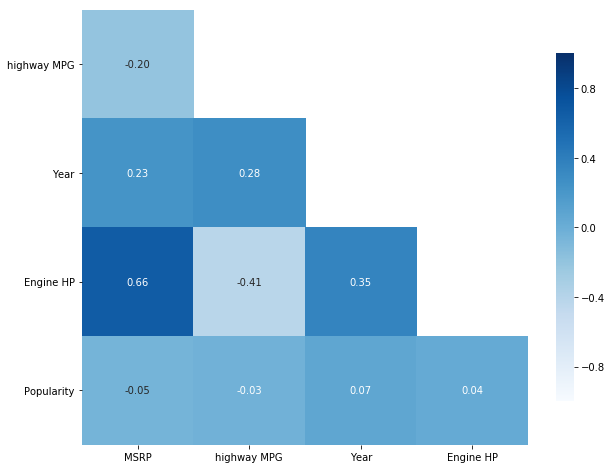

In [4]:
features = ['highway MPG', 'Year', 'Engine HP', 'Popularity']
import seaborn as sns
df_corr = df[['MSRP'] + features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

### Scatter plot using Matplotlib

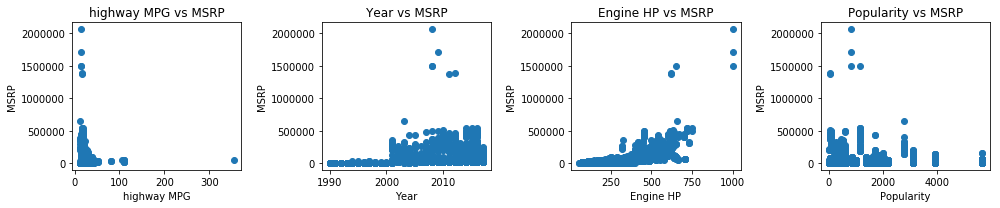

In [5]:
ncols = 4
nrows = (1 + len(features) % ncols)
plt.figure(figsize=(14,3))

for i in range(len(features)):
    plt.subplot(nrows, 4, i + 1)
    plt.scatter(features[i], 'MSRP', data=df)
    plt.xlabel(features[i])
    plt.title(f'{features[i]} vs MSRP')
    plt.ylabel('MSRP')
    plt.tight_layout()

### Scatter plot using Seaborn

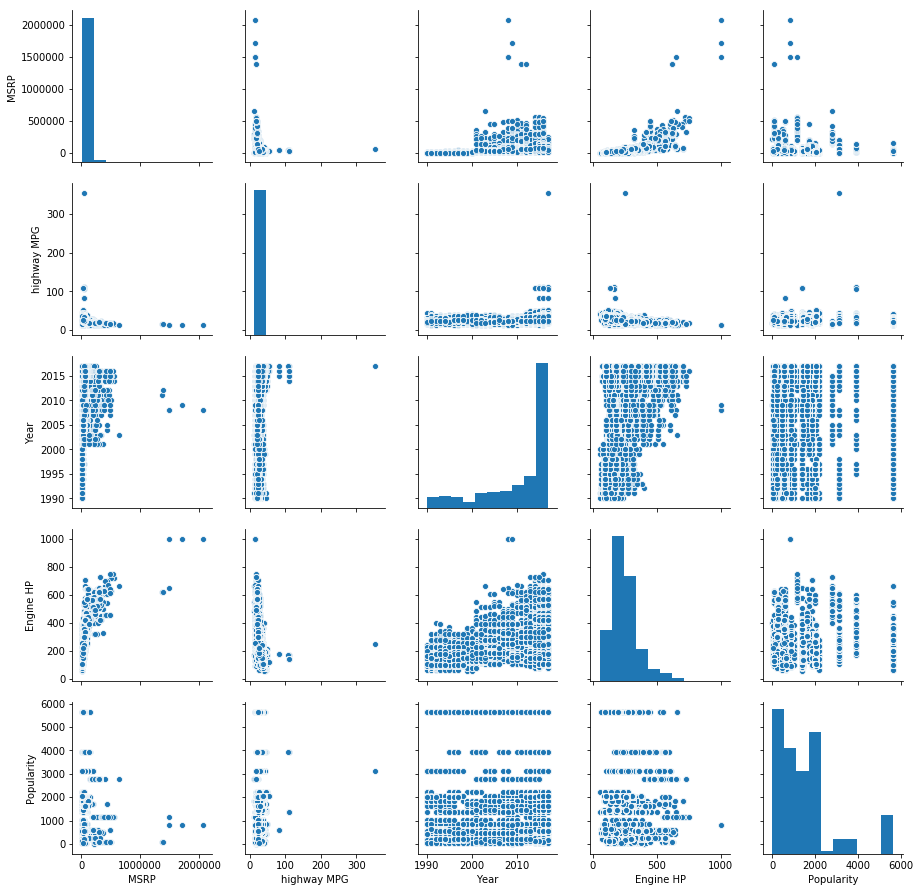

In [8]:
sns.pairplot(df[['MSRP'] + features])

# Feature Selection Linear Regression

1) If you are planning to use more than about 10 features I would recommend not using stepwise, or foward or baward selection, The number of possible combinations might take a long time to run, 

2) I suggest using a Lasso or RandomForest Regressor. Select features that
"
- https://towardsdatascience.com/feature-selection-techniques-in-regression-model-26878fe0e24e
- https://www.kaggle.com/talhahascelik/automated-stepwise-backward-and-forward-selection
- https://towardsdatascience.com/stopping-stepwise-why-stepwise-selection-is-bad-and-what-you-should-use-instead-90818b3f52df

In [4]:
df.head(1)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135


In [5]:
# Lets suppose we only have 3 features to predict price:
features = ['highway MPG', 'Year', 'Engine HP']

In [6]:
# POSSIBLE FEATURE COMBINATIONS:
# SINGLE FEATURE (3 OPTIONS)  ['highway MPG'] / ['Year'] / ['Engine HP']
# TWO FEATURES (3 OPTIONS)    ['highway MPG', 'Year'] / ['highway MPG', 'Engine HP'] / ['highway MPG', 'Engine HP']
# THREE FEATURES (1 OPTIONS)  ['highway MPG', 'Year', 'Engine HP']
# Total = 7 options

In [1]:
# n!/ k! (n - k)!

# 3C1 = 3
# 3C2 = 3
# 3C3 = 1
# Total = 7

# 4C1 = 4! / (1!* (4 - 1)!) = 4! / 3! = 4
# 4C2 = 4! / (2!* (4 - 2)!) = 4! / (2! * 2!) = 6
# 4C3 = 4! / (3!* (4 - 3)!) = 4! / 3! = 4
# 4C4 = 4! / (4!* (4 - 4)!) = 4! / 4! = 1
# Total = 15

In [46]:
def factorial(i):
    result = 1
    if i > 0:
        while i > 0:
            result *= i
            i -= 1
    return result

def combination(n, k):
    return factorial(n) / (factorial(k) * factorial(n-k))

def number_feature_comb(n):
    combinations = 0
    k = n
    while k > 0:
        combinations += combination(n,k)
        k -= 1
    return combinations


# Possible combinations of 20 features
number_feature_comb(20)

1048575.0

In [9]:
features = ['highway MPG', 'Year', 'Engine HP', 'Popularity']
# SINGLE FEATURE (4 OPTIONS)  ['highway MPG'] / ['Year'] / ['Engine HP'] / ['Popularity']
# TWO FEATURES (7 OPTIONS)    ['highway MPG', 'Year'] / ['highway MPG', 'Engine HP'] / ['highway MPG', 'Popularity']
#                             ['Year', 'Engine HP'] / ['Year', 'Popularity'] / ['Engine HP', 'Popularity']
#                                                      
# THREE FEATURES (3 OPTIONS)  ['highway MPG', 'Year', 'Engine HP'] / ['highway MPG', 'Year', 'Popularity']
#                             ['Year','Engine HP', 'Popularity']

# FOUR FEATURES (1 OPTIOON) ['highway MPG', 'Year', 'Engine HP', 'Popularity']
# Total = 14 options

# Step Wise Feature Selection

In [57]:
# Function to add results to df
def add_featues_to_df(results, df):
    result_dic = {'aic': results.aic,
                  'rsquare':results.rsquared,
                  'rsquareadj':results.rsquared_adj,
                  'Coeficients': results.params.round(2).to_dict(),
                  'pvalues': results.pvalues.round(3).to_dict()
                 }
    feature_comp = pd.DataFrame.from_dict(result_dic, orient='index').T
    feature_comp['nfeatures'] = len(result_dic['Coeficients']) - 1
    df = pd.concat([df, feature_comp])
    return df

In [58]:
f_comp = pd.DataFrame()

In [59]:
# 1) Run Model with each individual of feature
y = df['MSRP']
X = df['highway MPG']
X_2 = sm.add_constant(X)
model = sm.OLS(y, X_2)
results = model.fit()
f_comp = add_featues_to_df(results, f_comp)
# print(results.summary())
# print('R2: ', results.rsquared)

In [60]:
y = df['MSRP']
X = df['Engine HP']
X_2 = sm.add_constant(X)
model = sm.OLS(y, X_2)
results = model.fit()
f_comp = add_featues_to_df(results, f_comp)
# print(results.summary())
# print('R2: ', results.rsquared)

In [61]:
y = df['MSRP']
X = df['Year']
X_2 = sm.add_constant(X)
model = sm.OLS(y, X_2)
results = model.fit()
f_comp = add_featues_to_df(results, f_comp)
# print(results.summary())
# print('R2: ', results.rsquared)

# Check results for 1 feature 

In [62]:
f_comp

,aic,rsquare,rsquareadj,Coeficients,pvalues,nfeatures
0,293184,0.0397088,0.0396275,"{'const': 83081.19, 'highway MPG': -1614.96}","{'const': 0.0, 'highway MPG': 0.0}",1
0,286841,0.4386,0.438552,"{'const': -50651.98, 'Engine HP': 365.62}","{'const': 0.0, 'Engine HP': 0.0}",1
0,293036,0.05168,0.0515997,"{'const': -3589570.37, 'Year': 1805.72}","{'const': 0.0, 'Year': 0.0}",1


# Continue Stepwise using Engine HP

In [63]:
y = df['MSRP']
X = df[['Engine HP','Year']]
X_2 = sm.add_constant(X)
model = sm.OLS(y, X_2)
results = model.fit()
f_comp = add_featues_to_df(results, f_comp)
# print(results.summary())
# print('R2: ', results.rsquared)

In [64]:
y = df['MSRP']
X = df[['Engine HP','highway MPG']]
X_2 = sm.add_constant(X)
model = sm.OLS(y, X_2)
results = model.fit()
f_comp = add_featues_to_df(results, f_comp)
# print(results.summary())
# print('R2: ', results.rsquared)

In [65]:
f_comp

,aic,rsquare,rsquareadj,Coeficients,pvalues,nfeatures
0,293184,0.0397088,0.0396275,"{'const': 83081.19, 'highway MPG': -1614.96}","{'const': 0.0, 'highway MPG': 0.0}",1
0,286841,0.4386,0.438552,"{'const': -50651.98, 'Engine HP': 365.62}","{'const': 0.0, 'Engine HP': 0.0}",1
0,293036,0.05168,0.0515997,"{'const': -3589570.37, 'Year': 1805.72}","{'const': 0.0, 'Year': 0.0}",1
0,286842,0.438646,0.438551,"{'const': 65224.37, 'Engine HP': 367.04, 'Year': -57.82}","{'const': 0.578, 'Engine HP': 0.0, 'Year': 0.323}",2
0,286699,0.445415,0.445321,"{'const': -75178.0, 'Engine HP': 386.37, 'highway MPG': 735.14}","{'const': 0.0, 'Engine HP': 0.0, 'highway MPG': 0.0}",2


# Continue Stepwise using Engine HP & 'highway MPG'

In [66]:
y = df['MSRP']
X = df[['Engine HP','highway MPG', 'Year']]
X_2 = sm.add_constant(X)
model = sm.OLS(y, X_2)
results = model.fit()
f_comp = add_featues_to_df(results, f_comp)
# print(results.summary())
# print('R2: ', results.rsquared)

In [67]:
f_comp

,aic,rsquare,rsquareadj,Coeficients,pvalues,nfeatures
0,293184,0.0397088,0.0396275,"{'const': 83081.19, 'highway MPG': -1614.96}","{'const': 0.0, 'highway MPG': 0.0}",1
0,286841,0.4386,0.438552,"{'const': -50651.98, 'Engine HP': 365.62}","{'const': 0.0, 'Engine HP': 0.0}",1
0,293036,0.05168,0.0515997,"{'const': -3589570.37, 'Year': 1805.72}","{'const': 0.0, 'Year': 0.0}",1
0,286842,0.438646,0.438551,"{'const': 65224.37, 'Engine HP': 367.04, 'Year': -57.82}","{'const': 0.578, 'Engine HP': 0.0, 'Year': 0.323}",2
0,286699,0.445415,0.445321,"{'const': -75178.0, 'Engine HP': 386.37, 'highway MPG': 735.14}","{'const': 0.0, 'Engine HP': 0.0, 'highway MPG': 0.0}",2
0,286635,0.448508,0.448368,"{'const': 1008453.38, 'Engine HP': 407.83, 'highway MPG': 1021.59, 'Year': -545.44}","{'const': 0.0, 'Engine HP': 0.0, 'highway MPG': 0.0, 'Year': 0.0}",3


In [ ]:
.feature_importance()

In [133]:
# First feature selected is Engine HP, since it has p-value < 0.05 and lowest AIC.
y = df['MSRP']
X = df[['Engine HP']]
X_2 = sm.add_constant(X)
model = sm.OLS(y, X_2)
results = model.fit()
f_comp = add_featues_to_df(results, f_comp)
# print(results.summary())
# print('R2: ', results.rsquared)

In [134]:
f_comp['const_coef'] = f_comp['Coeficients'].map(lambda x: x['const'])
f_comp['Coeficients'] = f_comp['Coeficients'].map(lambda x: list(zip(list(x.keys())[1:], list(x.values())[1:])))

f_comp['const_pvalue'] = f_comp['pvalues'].map(lambda x: x['const'])
f_comp['pvalues'] = f_comp['pvalues'].map(lambda x: list(zip(list(x.keys())[1:], list(x.values())[1:])))

f_comp = f_comp.sort_values('nfeatures')
f_comp

,aic,rsquare,rsquareadj,Coeficients,pvalues,nfeatures,const_coef,const_pvalue
0,293184,0.0397088,0.0396275,"[(highway MPG, -1614.96)]","[(highway MPG, 0.0)]",1,83081.19,0.000
0,293036,0.05168,0.0515997,"[(Year, 1805.72)]","[(Year, 0.0)]",1,-3589570.37,0.000
0,286841,0.4386,0.438552,"[(Engine HP, 365.62)]","[(Engine HP, 0.0)]",1,-50651.98,0.000
0,286842,0.438646,0.438551,"[(Engine HP, 367.04), (Year, -57.82)]","[(Engine HP, 0.0), (Year, 0.323)]",2,65224.37,0.578
0,286699,0.445415,0.445321,"[(Engine HP, 386.37), (highway MPG, 735.14)]","[(Engine HP, 0.0), (highway MPG, 0.0)]",2,-75178.00,0.000
0,286635,0.448508,0.448368,"[(Engine HP, 407.83), (highway MPG, 1021.59), (Year, -545.44)]","[(Engine HP, 0.0), (highway MPG, 0.0), (Year, 0.0)]",3,1008453.38,0.000


In [ ]:
columns_to_dummy = ['Vehicle Style']
dummies_df = pd.get_dummies(df[columns_to_dummy], drop_first=True,)
df2 = pd.concat([df, dummies_df], axis=1)

In [ ]:
y = df2[PRICE]
x = df2[[HP] + list(dummies_df.columns)]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [ ]:
corr = df2.corr()

In [ ]:
sns.heatmap(corr)

In [ ]:
df.columns

In [ ]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
selected_columns = df2.columns[columns]
data = df2[selected_columns]